# Stats Project

## Intro/Background

In this project, I wanted to explore various cross validation techniques. I compare the accuracy of regressions generated through in-sample cross validation with the accuracy of a "real regression" not bound by the data in one sample. 


## Data Generating for Regression

I start by creating a data generating function for a linear regression problem, with four non-independent random gaussian variables. The variables and resulting regression are plotted below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression


/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [65]:
def generate_date(coeffs,n):
    x1 = np.random.normal(0, 0.1, n)
    x2 = np.random.normal(.5, 0.3, n) + x1
    x3 = np.random.normal(.3, 0.1, n) - x2
    x4 = np.random.normal(0, 0.7, n) + x3
    y = coeffs[0]*x1 + coeffs[1]*x2 + coeffs[2]*x3 + coeffs[3]*x4 + np.random.normal(.2,.1,n)

    df1 = pd.DataFrame({
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'x4': x4,
        'y': y
        })
    return df1

In [66]:
coeffs = [4,.3,2,6]
n = 10000
df1 = generate_date(coeffs,n)  
df1.head()


,x1,x2,x3,x4,y
0,0.122769,0.063129,0.275103,-0.283558,-0.458778
1,0.026644,0.271593,0.035841,-0.237415,-1.139278
2,0.140555,0.231697,0.169368,0.502667,4.223921
3,-0.032732,0.781883,-0.322256,-0.105548,-1.083051
4,0.125692,0.528392,-0.239317,0.304999,2.151141


<AxesSubplot:xlabel='y', ylabel='Density'>

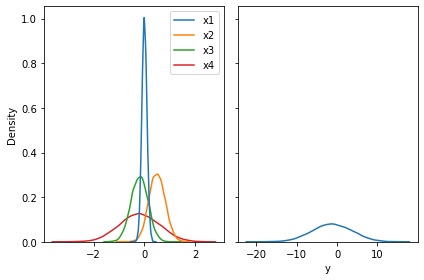

In [69]:
X = df1.drop(['y'], axis=1)
y = df1.y

fig, axes = plt.subplots(1, 2, sharey=True, tight_layout=True)
sns.kdeplot(data=X,ax=axes[0])
sns.kdeplot(data=y,ax=axes[1])


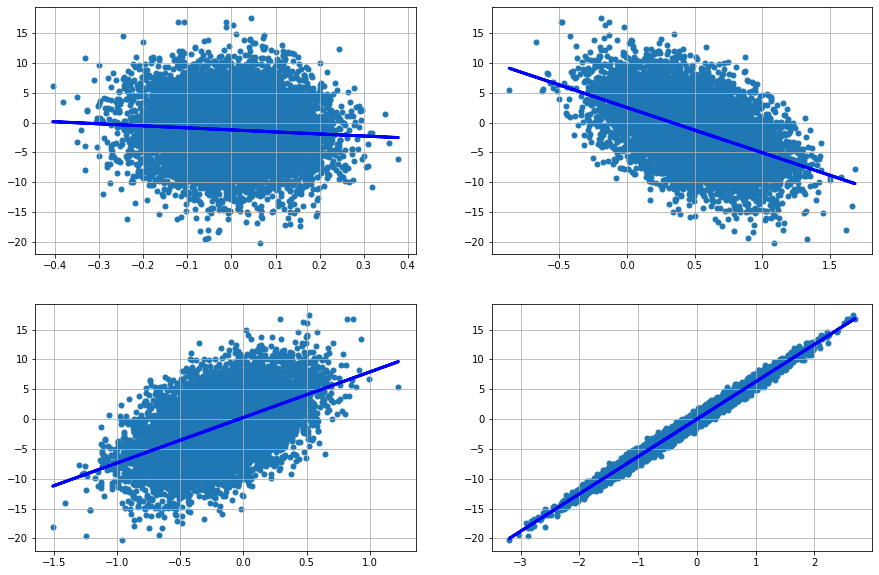

In [103]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    fit = np.polyfit(df1[df1.columns[i-1]],df1['y'],1)
    fit_fn = np.poly1d(fit)
    plt.subplot(2,2,i)
    plt.scatter(df1[df1.columns[i-1]],df1['y'],s=25)
    plt.plot(df1[df1.columns[i-1]],fit_fn(df1[df1.columns[i-1]]),'b-',lw=3)
    plt.grid(True)

Now we can do a linear regression on the data, and compare the generated Y values to the actual y values. We can also see the predicted coefficients. Even though we are using all of the data, the coefficients are not exactly the same as the real values, because the random variables we are using will never cover all possible points.

In [97]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)

print(reg.score(X, y), reg.coef_, reg.intercept_,)

ydf = pd.DataFrame({'Actual': y,'Predicted':reg.predict(X)})
ydf

0.9995901576078723 [3.99363006 0.30271435 2.00612713 6.00018545] 0.19941053208046533


,Actual,Predicted
0,-0.458778,-0.440691
1,-1.139278,-0.964600
2,4.223921,4.186740
3,-1.083051,-0.974418
4,2.151141,2.211277
...,...,...
9995,10.741289,10.834540
9996,-9.545665,-9.454269
9997,3.235467,3.246162
9998,-6.632672,-6.692307


By running this regression over and over on different sets of generated values, we can draw the "true" distribution of the coefficients.

In [98]:
import itertools

for _ in itertools.repeat(None, 100):
    X = df1.drop(['y'], axis=1)
    y = df1.y
    df1 = generate_date(coeffs,n) 
    reg = LinearRegression().fit(X, y)
    print(reg.coef_)

[3.99363006 0.30271435 2.00612713 6.00018545]
[3.99940373 0.29954866 1.99782286 5.9975357 ]
[3.99277274 0.3070858  2.00273667 5.99857547]
[4.00851932 0.30596756 2.00733815 5.99939413]
[3.99390881 0.29310985 1.9950223  5.99724175]
[4.01019933 0.29995363 1.99958021 5.99961125]
[4.00330758 0.30731506 2.00979594 5.99893241]
[3.99465848 0.30619725 2.0073668  6.00087521]
[4.00989374 0.29705163 2.00264222 5.99671763]
[4.01471729 0.2988509  2.0075422  5.99836641]
[3.99991337 0.28246749 1.97981412 5.99841402]
[4.00798124 0.28802085 1.99055127 6.0009798 ]
[3.99610921 0.31272414 2.01351471 6.00059079]
[3.9927047  0.29146138 1.99530238 5.9999053 ]
[3.99701034 0.28342993 1.9879126  5.99952105]
[3.98957145 0.30021724 1.99784883 5.99908106]
[3.99394134 0.31065755 2.01553895 5.997094  ]
[3.99713736 0.3227836  2.02451717 5.99861474]
[4.00838028 0.28629174 1.98928649 5.99902962]
[4.02049902 0.30505354 2.00636043 6.00112965]
[4.00832979 0.29561602 1.99159734 6.00006847]
[4.00080583 0.3232007  2.02254547 


In real experiments, we will never have the ability to resample all the data and come up with the true distribution. We have to commit to one sample and use in-sample data. This is where cross-validation comes in. In the next section I will use one set of the data I generated using the function defined in this section, and create test-train splits using various cross-validation techniques. I will compare parameter stability and predictive power using the cross validated sample to the real distribution from this section.


## Cross validation of linear models

Different types of cross-validation that I will explore:
- leave-p-out cross validation
- leave-one-out cross validation
- repeated random sub-sampling
- k-fold cross validation

Measures of fit:
- mean squared error
- root mean squared error
- median absolute deviation

In [8]:
from sklearn import linear_model
from sklearn.model_selection import cross_validate


In [9]:
# this is the function to generate an array of scores for a given CV method:
# use linear regression

from sklearn import svm

def get_score_list(cv):
    scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = reg = LinearRegression().fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    return scores


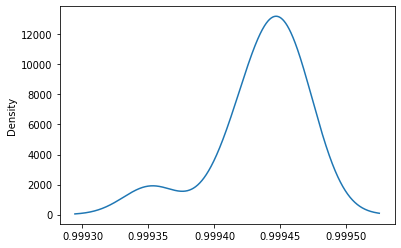

In [10]:
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split

# K-Fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)
# Returns the number of splitting iterations in the cross-validator
kf_scores = get_score_list(kf)

ax = pd.Series(kf_scores).plot.kde()


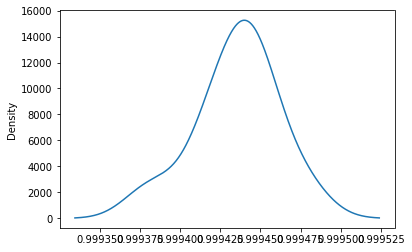

In [11]:
# Montecarlo cross-validation split
mc = ShuffleSplit(n_splits=10, test_size = 0.3 ,random_state=1)
# Returns the number of splitting iterations in the cross-validator
mc.get_n_splits(X)

mc_scores = get_score_list(mc)

ax = pd.Series(mc_scores).plot.kde()


In [12]:
from sklearn.utils import resample, check_random_state

# Single Bootstrap split
a = resample(X)
test = [item for item in X if item not in a]
print("Train:",a,"  Test:",test)

Train:             x1        x2        x3        x4
6412 -0.153109  0.166668  1.111868  1.847309
1698 -0.122148  0.061913  1.083867  1.895421
7943 -0.107562  0.377617  0.820631  1.256829
2548 -0.113922  0.373656  1.096054  2.070038
2969  0.012476  0.433544  1.235692  1.345298
...        ...       ...       ...       ...
5599  0.022814 -0.018783  1.033425  0.702361
8171  0.070806  0.260825  1.001533  1.922277
1440  0.184008  0.461528  1.110405  0.435851
8096  0.115488  0.705864  1.063913  2.786250
8091  0.084865  1.022455  0.977100 -0.314955

[10000 rows x 4 columns]   Test: []


In [13]:
class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5, random_state=None):
        self.nb = n_bootstraps
        self.rs = random_state
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        rng = check_random_state(self.rs)
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX, random_state=rng)
            test = [item for item in iX if item not in train]
            yield (train,test)
            

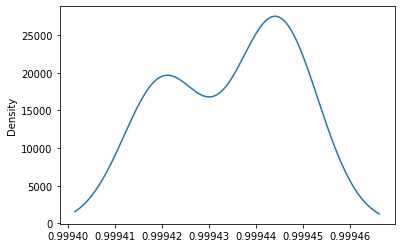

In [14]:
# Bootstrap cross-validator, consistent with similar classes in scikit-learn
boot = Bootstrap(n_bootstraps = 10, random_state=1)
boot_scores = get_score_list(boot)
ax = pd.Series(boot_scores).plot.kde()


    

<Figure size 1080x720 with 0 Axes>

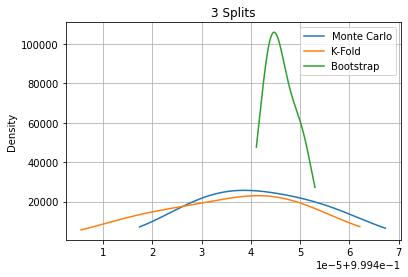

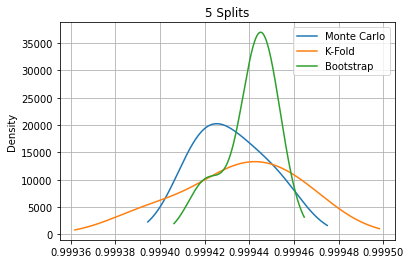

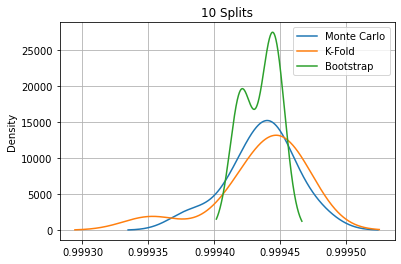

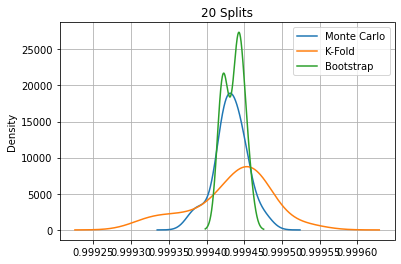

In [15]:
plt.figure(figsize=(15,10))
splits = [3,5,10,20]
for i in splits:
    
    boot = Bootstrap(n_bootstraps = i, random_state=1)
    kf = KFold(n_splits=i, shuffle=True, random_state=1)
    mc = ShuffleSplit(n_splits=i, test_size = 0.3 ,random_state=1)
    
    df = pd.DataFrame({
        'Monte Carlo': get_score_list(mc),
        'K-Fold': get_score_list(kf),
        'Bootstrap': get_score_list(boot)
    })
    ax = df.plot.kde()
    plt.title(f'{i} Splits')
    plt.grid(True)

Sources:
- [Data Generation](https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Synthetic_data_generation/Synthetic-Data-Generation.ipynb)
- [8 Types of Cross-Validation](https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d)
- [K Fold, Montecarlo, and Bootstrap](https://nirpyresearch.com/kfold-montecarlo-cross-validation-bootstrap-primer/)